<a href="https://colab.research.google.com/github/mr-fredi/MachineLearning/blob/main/Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/news.csv')
print('shape =', df.shape)
df.head(10)

shape = (6335, 4)


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE
6,7341,Girl Horrified At What She Watches Boyfriend D...,"Share This Baylee Luciani (left), Screenshot o...",FAKE
7,95,‘Britain’s Schindler’ Dies at 106,A Czech stockbroker who saved more than 650 Je...,REAL
8,4869,Fact check: Trump and Clinton at the 'commande...,Hillary Clinton and Donald Trump made some ina...,REAL
9,2909,Iran reportedly makes new push for uranium con...,Iranian negotiators reportedly have made a las...,REAL


In [ ]:
df.describe(include='all')

,Unnamed: 0,title,text,label
count,6335.000000,6335,6335,6335
unique,NaN,6256,6060,2
top,NaN,OnPolitics | 's politics blog,"Killing Obama administration rules, dismantlin...",REAL
freq,NaN,5,58,3171
mean,5280.415627,NaN,NaN,NaN
std,3038.503953,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,2674.500000,NaN,NaN,NaN
50%,5271.000000,NaN,NaN,NaN
75%,7901.000000,NaN,NaN,NaN


In [ ]:
df.isnull().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [ ]:
## very well balanced data set at 50/50
df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [ ]:
a = 3171 / (3171+3164)
print(a)

0.5005524861878453


In [ ]:
ground_truth = df.label

## train/test split
x_train,x_test,y_train,y_test=train_test_split(df['text'], ground_truth, test_size=0.2, random_state=1)

In [ ]:
#create a TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

#Fit and transform train set, transform test set 
## TO-DO: understand what's going on here
tfidf_train = tfidf_vectorizer.fit_transform(x_train) 
tfidf_test = tfidf_vectorizer.transform(x_test)

<1x60645 sparse matrix of type '<class 'numpy.float64'>'
	with 472 stored elements in Compressed Sparse Row format>

In [ ]:
#Create the PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(C=100, max_iter=75, early_stopping=True, loss="squared_hinge")
pac.fit(tfidf_train,y_train)

#Check model accuracy against test set
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 94.08%


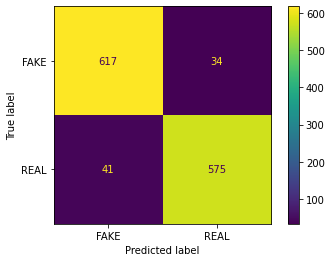

In [ ]:
#confusion matrix
cm = confusion_matrix(y_test,y_pred, labels=['FAKE','REAL'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pac.classes_)
disp.plot()
plt.show()

In [ ]:
##cross validate initial PAC model
result = cross_val_score(pac, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)

CV test accuracy: 0.9305443163302695
[0.9270217  0.92307692 0.91913215 0.93491124 0.93096647 0.92110454
 0.93293886 0.9566075  0.91501976 0.94466403]


In [ ]:
#Tuning the PassiveAggressiveClassifier - Default
pac = PassiveAggressiveClassifier()

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(pac, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)
pac.fit(tfidf_train,y_train)

#Check model accuracy against test set
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

CV test accuracy: 0.9333076065517536
[0.92110454 0.93491124 0.91715976 0.93491124 0.93096647 0.94674556
 0.93096647 0.94674556 0.91699605 0.95256917]
Accuracy: 94.48%


In [ ]:
#Tuning the PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(C=.01)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(pac, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)
pac.fit(tfidf_train,y_train)

#Check model accuracy against test set
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

CV test accuracy: 0.934689836362077
[0.91913215 0.93293886 0.91518738 0.94477318 0.93491124 0.93885602
 0.93491124 0.94871795 0.91897233 0.95849802]
Accuracy: 94.95%


In [ ]:
#Tuning the PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(C=.01, max_iter=500)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(pac, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)
pac.fit(tfidf_train,y_train)

#Check model accuracy against test set
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

CV test accuracy: 0.934887464820575
[0.91913215 0.93293886 0.91518738 0.94477318 0.93491124 0.93885602
 0.93491124 0.94871795 0.91897233 0.96047431]
Accuracy: 94.95%


In [ ]:
#Tuning the PassiveAggressiveClassifier
pac = PassiveAggressiveClassifier(C=.001, loss="squared_hinge", early_stopping=True, max_iter=5000)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(pac, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)
pac.fit(tfidf_train,y_train)

#Check model accuracy against test set
y_pred=pac.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

CV test accuracy: 0.8614873977750233
[0.85798817 0.85009862 0.85207101 0.85601578 0.87573964 0.84615385
 0.8678501  0.8678501  0.87351779 0.86758893]
Accuracy: 87.53%


In [ ]:
##testing KNeighbors
#Tuning the KN
kn = KNeighborsClassifier(n_neighbors=101, weights='distance', algorithm='auto')

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(kn, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)
kn.fit(tfidf_train,y_train)

#Check model accuracy against test set
y_pred=kn.predict(tfidf_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

CV test accuracy: 0.8447119769862246
[0.85996055 0.82445759 0.81854043 0.85207101 0.84615385 0.87179487
 0.83431953 0.85009862 0.83201581 0.85770751]
Accuracy: 87.61%


In [ ]:
## train / validate mulitple other models using cross validation & compare
models = []

models.append(("Passive Aggresive", PassiveAggressiveClassifier(C=.01, max_iter=500)))
models.append(("LinearSVC",LinearSVC()))
models.append(("SVC",SVC()))
models.append(("LogisticRegression",LogisticRegression()))
models.append(("KNeighbors",KNeighborsClassifier(n_neighbors=101, weights='distance', algorithm='auto')))
models.append(("DecisionTree",DecisionTreeClassifier()))
models.append(("RandomForest",RandomForestClassifier()))
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
                                max_depth=10, random_state=0, max_features=None)
models.append(("RandomForest2",rf2))
#models.append(("MLPClassifier",MLPClassifier(solver='lbfgs', random_state=0)))


results = []
names = []
for name,model in models:
    result = cross_val_score(model, tfidf_train, y_train,  cv=10)
    names.append(name)
    results.append(result)

models.append(("MLPClassifier",MLPClassifier(solver='adam', random_state=0)))
result = cross_val_score(model, tfidf_train, y_train,  cv=3)
names.append("MLPClassifier")
results.append(result)

for i in range(len(names)):
    print(names[i],results[i].mean())

Passive Aggresive 0.9350847034793522
LinearSVC 0.9344918181038583
SVC 0.9265952553577973
LogisticRegression 0.9117972885531413
KNeighbors 0.8447119769862246
DecisionTree 0.8206465218170903
RandomForest 0.9029160917120784
RandomForest2 0.8589182278145489
MLPClassifier 0.8480669093321094


In [ ]:
#testing multiple models on test data before hypertuning all

results_test = []
names_test = []
for name,model in models:
  trained_model = model.fit(tfidf_train, y_train)
  X_test_prediction = trained_model.predict(tfidf_test)
  test_data_accuracy = accuracy_score(X_test_prediction, y_test)
  names_test.append(name)
  results_test.append(test_data_accuracy)

for i in range(len(names_test)):
    print(names_test[i],results_test[i])

Passive Aggresive 0.9479084451460142
LinearSVC 0.9400157853196527
SVC 0.941594317284925
LogisticRegression 0.9297553275453828
KNeighbors 0.8760852407261247
DecisionTree 0.813733228097869
RandomForest 0.9076558800315706
RandomForest2 0.8658247829518547
MLPClassifier 0.9494869771112865


In [ ]:
#HYPERTUNED FINAL RESULTS (to screnshot)
## see cells below to view various model tuning attempts
#testing multiple hypertuned models on test data

models = []

models.append(("PassiveAggressive", PassiveAggressiveClassifier(C=.01, max_iter=500)))
models.append(("MLPClassifier",MLPClassifier(solver='adam', random_state=0, max_iter=800)))
models.append(("LinearSVC",LinearSVC(loss='hinge')))
models.append(("LogisticRegression",LogisticRegression()))
models.append(("SVC",SVC()))

models.append(("KNeighbors",KNeighborsClassifier(n_neighbors=101, weights='distance', algorithm='auto')))
models.append(("DecisionTree",DecisionTreeClassifier(criterion="entropy")))
models.append(("RandomForest",RandomForestClassifier()))
rf2 = RandomForestClassifier(n_estimators=100, criterion='gini',
                                max_depth=10, random_state=0, max_features=None)
models.append(("RandomForest2",rf2))


results_test = []
names_test = []
x_test_predictions = []
classification_reports = []
for name,model in models:
  trained_model = model.fit(tfidf_train, y_train)
  X_test_prediction = trained_model.predict(tfidf_test)
  x_test_predictions.append(X_test_prediction)
  report = classification_report(y_test,X_test_prediction)
  classification_reports.append(report)
  test_data_accuracy = accuracy_score(X_test_prediction, y_test)

  names_test.append(name)
  results_test.append(test_data_accuracy)
  print("done:", name)

for i in range(len(names_test)):
    print(names_test[i],results_test[i], classification_reports[i])

done: PassiveAggressive
done: MLPClassifier
done: LinearSVC
done: LogisticRegression
done: SVC
done: KNeighbors
done: DecisionTree
done: RandomForest
done: RandomForest2
PassiveAggressive 0.9486977111286503               precision    recall  f1-score   support

        FAKE       0.95      0.95      0.95       651
        REAL       0.95      0.95      0.95       616

    accuracy                           0.95      1267
   macro avg       0.95      0.95      0.95      1267
weighted avg       0.95      0.95      0.95      1267

MLPClassifier 0.9494869771112865               precision    recall  f1-score   support

        FAKE       0.95      0.95      0.95       651
        REAL       0.95      0.95      0.95       616

    accuracy                           0.95      1267
   macro avg       0.95      0.95      0.95      1267
weighted avg       0.95      0.95      0.95      1267

LinearSVC 0.9447513812154696               precision    recall  f1-score   support

        FAKE       0.9

In [ ]:
for i in range(len(names_test)):
    print(names_test[i],results_test[i])

PassiveAggressive 0.9486977111286503
MLPClassifier 0.9494869771112865
LinearSVC 0.9447513812154696
LogisticRegression 0.9297553275453828
SVC 0.941594317284925
KNeighbors 0.8760852407261247
DecisionTree 0.8042620363062352
RandomForest 0.9116022099447514
RandomForest2 0.8658247829518547


In [ ]:
##LienarSVC tuning 1
clf = LinearSVC(loss='hinge')

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=10)
print("CV train accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


CV train accuracy: 0.9346921751604025
[0.90532544 0.93293886 0.9408284  0.93293886 0.92899408 0.93688363
 0.93293886 0.94674556 0.93478261 0.95454545]
test accuracy: 0.9431728492501973


In [ ]:
##LienarSVC tuning 2 (same max score found)
clf = LinearSVC(loss='hinge', C=1.11, max_iter=5000)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

CV test accuracy: 0.9356799276531718
[0.90532544 0.93688363 0.93885602 0.93096647 0.9270217  0.93885602
 0.93491124 0.94674556 0.93675889 0.96047431]
test accuracy: 0.9431728492501973


In [ ]:
##LienarSVC tuning 3 (same max score found)
clf = LinearSVC(dual=False, C=0.75, max_iter=5000)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

CV test accuracy: 0.936664171948453
[0.90532544 0.93885602 0.94280079 0.93885602 0.92504931 0.94280079
 0.93885602 0.94674556 0.93083004 0.95652174]
test accuracy: 0.9431728492501973


# Decision Tree Fine-Tuning

The Decision Tree had a mid-range performance compared to other methods - coming in at 83%. In an exercise on fine-tuning, let's try to boost the performance. Let's delve into Scikit's DecisionTreeClassifier parameters to understand the moving parts

Source: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
* Criterion: 'gini' or 'entropy'
    
    The tree nodes are split using impurity, a measure of homogeneity of labels on a node.
    *  'entropy' splits the node to give the most amount of information gain
    *  'gini' measures divergences between probability distributions of the target attribute's values and splits the node to give the least amount of impurity
*Splitter: 'best' or 'random'
    * 'best' splitter evaluates all splits using the criterion before splitting. If you have hundreds of features, 'best' would be ideal to calculate the best features. Also good for a tree with few features without overfitting
    * 'random' uses random uniform function to split. It doesn't have the computation overhead of 'best' and is less prone to overfitting
*Max_features: int, float, string or None, option (default = None)

At every split, the algorithm looks for a number of features and takes on with optimal metric using impurity, and then two branches are created. Max-features allows us to look at some features instead of all of them so that you lessen the computation load. It also limits overfitting, thereby increasing tree stability. 
    * 'auto': max_features=sqrt(n_features)
    * 'sqrt': max_features=sqrt(n_features)
    * 'log2': max_features=log2(n_features). Try this if there is high computational cost or a lot of overfitting. You can then proceed to bring it up slightly using sqrt or take it down with a custom float
    * 'none': max_features=n_features

In [ ]:
#Decision Tree Fine Tuning 1
clf = DecisionTreeClassifier(criterion="entropy")
#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

CV test accuracy: 0.8157097083518489
[0.7790927  0.82445759 0.83234714 0.82840237 0.83234714 0.79487179
 0.81459566 0.80276134 0.8083004  0.83992095]
test accuracy: 0.8326756116811366


In [ ]:
# Decision Tree Fine Tuning 2
clf = DecisionTreeClassifier(criterion="entropy", splitter="random")
#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

CV test accuracy: 0.8042601211497532
[0.7790927  0.82445759 0.80473373 0.80473373 0.78500986 0.81854043
 0.81459566 0.81262327 0.80632411 0.79249012]
test accuracy: 0.7987371744277821


In [ ]:
#Decision Tree Fine Tuning 3
clf = DecisionTreeClassifier(criterion="entropy", splitter="random", max_features='sqrt')
#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=10)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

CV test accuracy: 0.7336182769293138
[0.75542406 0.7357002  0.74358974 0.72583826 0.71597633 0.74556213
 0.72583826 0.74358974 0.70948617 0.73517787]
test accuracy: 0.7079715864246251


The use of "entropy" criterion improved minimally (2%) the model's accuracy vs "gini" 

The use of 'random' to split the information and max_features calculated by 'sqrt' rather than a default of none caused a decrease in accuracy. Affect of max_features is because the model is not highly complex, and suggests we don't have an overfitting issue 

# MLP Classifier
Let's test how different weight optimizations affect MLP Classifier accuracy



*   'lbfgs' is optimizer in family of quasi-Newton methods
*   'sgd' is stochastic gradient descent
*   'adam' is stochastic gradient-based optimizer propsoed by Kingma, Diederik, and Jimmy Ba

According to scikit-learn, default solver 'adam' works on large datasets in training time and validation score.

'lbfgs' is more suited for small datasets since it can converge faster and perform better

In [ ]:
## MLP classifier tuning
clf = MLPClassifier(solver='sgd', random_state=0)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=3)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


CV test accuracy: 0.8224156071949486
[0.82011834 0.83362937 0.81349911]
test accuracy: 0.8500394632991318


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
## MLP classifier tuning
clf = MLPClassifier(solver='sgd', random_state=0, warm_start=True, max_iter=800)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=3)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

In [ ]:
## MLP Classifier Tuning 3
clf = MLPClassifier(solver='adam', random_state=0, max_iter=800)

#Cross Validate on 10 Stratified kfolds
result = cross_val_score(clf, tfidf_train, y_train,  cv=3)
print("CV test accuracy:", result.mean())
print(result)

trained_model = clf.fit(tfidf_train, y_train)
X_test_prediction = trained_model.predict(tfidf_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print("test accuracy:", test_data_accuracy)

In [ ]:
##trying some things from a kaggle notebook https://www.kaggle.com/code/akarsh1/fakenews-classification-using-ml-and-deep-learning/notebook

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow.keras.layers import Embedding,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional,GRU
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
ground_truth = df.label

## train/test split
x_train,x_test,y_train,y_test=train_test_split(df['text'], ground_truth, test_size=0.2, random_state=3)



In [ ]:

x_train

1740    A study conducted at QIMR Berghofer Medical Re...
3908    Hillary Clinton appears to have scared away mu...
6096    By Lasha Darkmoon on November 1, 2016 Tom Leon...
5932    Democratic presidential candidates Hillary Cli...
3473    He’s best known for bankrolling Republicans Ri...
                              ...                        
968     This video shows you how to structure water in...
1667    Cable news is in trouble. The Pew Research Cen...
3321    Students expressed their “fear” over a Trump p...
1688      \nNew Zealand’s   country’s entire east coas...
5994    \nIn the aftermath of one of the most memorabl...
Name: text, Length: 5068, dtype: object

In [ ]:
# Performing data preprocessing on column 'text'
## earlier tried on 'title' with poor results
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
def perform_preprocess(data):
    '''Input: Data to be processed
       Output: Preprocessed data
    '''
    corpus = []
    for i in range(0,len(data)):
        review = re.sub('[^a-zA-Z]',' ', data.iloc[i])
        review = review.lower()
        review = review.split()
        review = [ps.stem(word) for word in review if word not in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
    return corpus
    
train_corpus = perform_preprocess(x_train)
test_corpus  = perform_preprocess(x_test)
train_corpus[1]

'hillari clinton appear scare away much competit seek democrat nomin presid earli practic encompass effort also present potenti liabil sail primari season larg untest bare knuckl gener elect could deni democrat chanc defin american strategist say good parti democrat parti need real debat take countri say denni kucinich former democrat congressman presidenti candid fox news contributor year old clinton plan make offici announc earli leav doubt whether inde run frontrunn statu unquestion roughli percent like vote lead potenti democrat challeng numb percentag point number combin ambiti public speak schedul fundrais cheerlead group readi hillari make difficult potenti primari challeng rais money addit clinton formid like primari challeng massachusett sen elizabeth warren insist run leav democrat field wide open year old berni sander independ junior senat vermont fourth behind clinton warren vice presid biden accord averag poll realclearpolit com think miss chanc vet ideal say richard fowle

In [ ]:
# Converting to one-hot repr.
vocab_size = 5000
one_hot_train = [one_hot(word,vocab_size) for word in train_corpus]
one_hot_test  = [one_hot(word,vocab_size) for word in test_corpus]

one_hot_test[3]

[2725,
 3523,
 2647,
 3723,
 857,
 3623,
 124,
 2761,
 4630,
 4295,
 1736,
 1225,
 2553,
 3635,
 708,
 4783,
 2045,
 943,
 315,
 1140,
 3134,
 2045,
 1287,
 175,
 1783,
 4830,
 2229,
 2761,
 201,
 2493,
 648,
 1337,
 2333,
 1337,
 2805,
 315,
 72,
 3228,
 2045,
 815,
 1783,
 3526,
 3005,
 1798,
 545,
 350,
 3244,
 2229,
 1409,
 2725,
 3523,
 2826,
 865,
 1889,
 1548,
 4812,
 910,
 3566,
 1993,
 2045,
 487,
 1761,
 4,
 598,
 141,
 3566,
 3905,
 3565,
 3669,
 3739,
 2915,
 1736,
 2423,
 1622,
 2725,
 2829,
 146,
 2045,
 487,
 628,
 4644,
 175,
 3228,
 4940,
 2179,
 4295,
 3419,
 2725,
 3523,
 1616,
 2411,
 2493,
 2642,
 1229,
 3990,
 3765,
 4940,
 1963,
 4082,
 1668,
 2217,
 3271,
 2725,
 3723,
 865,
 3576,
 1593,
 2572,
 1139,
 3407,
 4924,
 2380,
 601,
 189,
 889,
 437,
 988,
 3648,
 1872,
 2097,
 339,
 545,
 1696,
 1140,
 2695,
 3433,
 3648,
 2982,
 1322,
 2996,
 4974,
 2597,
 1622,
 874,
 2179,
 4295,
 1736,
 4869,
 3635]

In [ ]:
# Embedding Representation 
sent_length = 350
embedd_docs_train = pad_sequences(one_hot_train,padding='pre',maxlen=sent_length)
embedd_docs_test  = pad_sequences(one_hot_test,padding='pre',maxlen=sent_length)
print(embedd_docs_train[1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 2725 3523 1307  255  501 4923 4297 1403 3755 2524
 3828  998 3135 4074 4891 2970 1052 2180 4979 2678 1759  940 2112 4640
 2647  514 3540 3623 4602  395 3755 2572 2184  189  900 1668 3244    1
 3755    1 3576  828 1256  315 4286 1668 1718 2034 2022 3755   63  857
 3426  786 1062  833 1634 1696 3523 4286 4594  885 4014  998 2004 3466
  573 1402 3432 4497 1905  882 1438 3298 4940  137 1708 2180 3755 4969
 2948 2063  148 4281 2102 4721 2493 3352 1203 1622 4121 3561 4030 2725
 4594 1398 2180 1759 4969 1974 2294 3441 3523 2801 4940 1759 4969 3609
 3847 2154 3001 1944 3432 2004 3755 2292 4540 3388 1634 1696 4475  943
  911 

In [ ]:
# Converting Embedding repr. to array
x_final = np.array(embedd_docs_train)
y_final = np.array(y_train)
x_test_final = np.array(embedd_docs_test)
y_test_final = np.array(y_test)

In [ ]:
# Dimensions of prev. array repr.
x_final.shape,y_final.shape,x_test_final.shape,y_test_final.shape

((5068, 350), (5068,), (1267, 350), (1267,))

In [ ]:
model_1 = LogisticRegression(max_iter=900)
model_1.fit(x_final,y_final)
pred_1 = model_1.predict(x_test_final)
cr1    = classification_report(y_test_final,pred_1)
print(cr1)

              precision    recall  f1-score   support

        FAKE       0.63      0.60      0.62       638
        REAL       0.61      0.65      0.63       629

    accuracy                           0.62      1267
   macro avg       0.62      0.62      0.62      1267
weighted avg       0.62      0.62      0.62      1267



In [ ]:
model_2 = MultinomialNB()
model_2.fit(x_final,y_final)
pred_2 = model_2.predict(x_test_final)
cr2    = classification_report(y_test_final,pred_2)
print(cr2)

              precision    recall  f1-score   support

        FAKE       0.66      0.55      0.60       638
        REAL       0.61      0.71      0.66       629

    accuracy                           0.63      1267
   macro avg       0.63      0.63      0.63      1267
weighted avg       0.63      0.63      0.63      1267



In [ ]:
model_3 = DecisionTreeClassifier()
model_3.fit(x_final,y_final)
pred_3 = model_3.predict(x_test_final)
cr3    = classification_report(y_test_final,pred_3)
print(cr3)

              precision    recall  f1-score   support

        FAKE       0.64      0.63      0.63       638
        REAL       0.63      0.63      0.63       629

    accuracy                           0.63      1267
   macro avg       0.63      0.63      0.63      1267
weighted avg       0.63      0.63      0.63      1267



In [ ]:
model_4 = RandomForestClassifier()
model_4.fit(x_final,y_final)
pred_4 = model_4.predict(x_test_final)
cr4    = classification_report(y_test_final,pred_4)
print(cr4)

              precision    recall  f1-score   support

        FAKE       0.72      0.57      0.64       638
        REAL       0.64      0.77      0.70       629

    accuracy                           0.67      1267
   macro avg       0.68      0.67      0.67      1267
weighted avg       0.68      0.67      0.67      1267



In [ ]:
model_5 = XGBClassifier()
model_5.fit(x_final,y_final)
pred_5 = model_5.predict(x_test_final)
cr5    = classification_report(y_test_final,pred_5)
print(cr5)

              precision    recall  f1-score   support

        FAKE       0.73      0.60      0.66       638
        REAL       0.66      0.78      0.71       629

    accuracy                           0.69      1267
   macro avg       0.69      0.69      0.68      1267
weighted avg       0.69      0.69      0.68      1267



In [ ]:
# Creating the LSTM Model for prediction
embedding_feature_vector = 40
model = Sequential()
model.add(Embedding(vocab_size,embedding_feature_vector,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 350, 40)           200000    
                                                                 
 dropout_2 (Dropout)         (None, 350, 40)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               56400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 256,501
Trainable params: 256,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train, x_valid, Y_train, y_valid = train_test_split(x_final, y_final, test_size=0.1, random_state=42, stratify = y_train)



In [ ]:
for i in range(0,len(Y_train)):
  if Y_train[i] == 'REAL':
    Y_train[i] = 0
  else:
    Y_train[i] = 1

Y_train


array([0, 0, 1, ..., 1, 1, 1], dtype=object)

In [ ]:
for i in range(0,len(y_valid)):
  if y_valid[i] == 'REAL':
    y_valid[i] = 0
  else:
    y_valid[i] = 1

y_valid

array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0,

In [ ]:
y_valid = np.asarray(y_valid).astype('int32')
Y_train = np.asarray(Y_train).astype('int32')

In [ ]:
# Training the model
model.fit(X_train,Y_train,validation_data=(x_valid,y_valid),epochs=10,batch_size=64)

Epoch 1/10
72/72 [==============================] - 40s 510ms/step - loss: 0.6512 - accuracy: 0.6328 - val_loss: 0.4851 - val_accuracy: 0.8166
Epoch 2/10
72/72 [==============================] - 35s 490ms/step - loss: 0.3157 - accuracy: 0.8717 - val_loss: 0.3592 - val_accuracy: 0.8422
Epoch 3/10
72/72 [==============================] - 38s 524ms/step - loss: 0.2086 - accuracy: 0.9290 - val_loss: 0.3634 - val_accuracy: 0.8560
Epoch 4/10
72/72 [==============================] - 33s 463ms/step - loss: 0.1313 - accuracy: 0.9542 - val_loss: 0.3387 - val_accuracy: 0.8659
Epoch 5/10
72/72 [==============================] - 36s 497ms/step - loss: 0.0959 - accuracy: 0.9684 - val_loss: 0.3697 - val_accuracy: 0.8462
Epoch 6/10
72/72 [==============================] - 34s 472ms/step - loss: 0.1058 - accuracy: 0.9627 - val_loss: 0.4220 - val_accuracy: 0.8797
Epoch 7/10
72/72 [==============================] - 32s 450ms/step - loss: 0.0604 - accuracy: 0.9820 - val_loss: 0.4516 - val_accuracy: 0.8836

In [ ]:
for i in range(0,len(y_test_final)):
  if y_test_final[i] == 'REAL':
    y_test_final[i] = 0
  elif y_test_final[i] == 'FAKE':
    y_test_final[i] = 1

y_test_final

array([0, 1, 0, ..., 1, 1, 0], dtype=object)

In [ ]:
y_test_final = np.asarray(y_test_final).astype('int32')

In [ ]:
predictions = (model.predict(x_test_final) > 0.5).astype("int32")
cr = classification_report(y_test_final,predictions)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       629
           1       0.88      0.76      0.82       638

    accuracy                           0.83      1267
   macro avg       0.83      0.83      0.83      1267
weighted avg       0.83      0.83      0.83      1267



array([[0],
       [1],
       [0],
       ...,
       [1],
       [1],
       [0]], dtype=int32)